### Imports

In [ ]:
# imports

!python -m pip install --upgrade plotly

import kaleido
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Preprocessing

In [11]:
# import, preprocess, and look over raw data

df = pd.read_csv("data/data_04_29_2025.csv")
df = df.dropna(subset=['DatasetID'])
df.replace("n/a", "", inplace=True)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df.rename(columns={'iEEG modality': 'iEEG Modality'}, inplace=True)
df = df[df['DatasetID'] != 'ds004215']

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_52859/594261442.py:6: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_52859/594261442.py:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



### Figure 1

Figure 1 - Author country x # of datasets x authors from multiple institutions

A world map showing the distribution of author countries. Use circles of varying sizes to represent the number of studies from each country, use heat map to show how many of those studies from each country were collaboration with another institution 


In [ ]:
# Define European countries
european_countries = [
    'albania', 'andorra', 'armenia', 'austria', 'azerbaijan', 'belarus', 'belgium', 
    'bosnia and herzegovina', 'bulgaria', 'croatia', 'cyprus', 'czech republic', 'czechia',
    'denmark', 'estonia', 'finland', 'france', 'georgia', 'germany', 'greece', 
    'hungary', 'iceland', 'ireland', 'italy', 'kazakhstan', 'kosovo', 'latvia', 
    'liechtenstein', 'lithuania', 'luxembourg', 'malta', 'moldova', 'monaco', 
    'montenegro', 'netherlands', 'north macedonia', 'norway', 'poland', 'portugal', 
    'romania', 'russia', 'san marino', 'serbia', 'slovakia', 'slovenia', 'spain', 
    'sweden', 'switzerland', 'turkey', 'ukraine', 'united kingdom', 'vatican city'
]

# create countries without US plot
countries = df['Author country']
countries = countries.astype(str)
countries = countries.str.strip().str.lower().str.replace('.', '')
replacements = {
    "usa": "united states",
    "uk": "united kingdom",
    "romani": "romania",
    'the netherlands': 'netherlands'
}
countries.replace(replacements, inplace=True)

countries_noUS = countries[countries != 'united states']
unique_countries_noUS, counts_noUS = np.unique(countries_noUS, return_counts=True)
country_counts_df = pd.DataFrame({
    'Country': unique_countries_noUS,
    'Count': counts_noUS
})

# Create US only plot
usa = df[['Author country', 'First author state']]
usa = usa.map(lambda x: x.strip().lower().replace('.', ''))
usa.replace({"usa": "united states"}, inplace=True)
usa = usa[usa['Author country'] == 'united states']

city_replacements = {
    'chicago': 'illinois',
    'pittsburgh': 'pennsylvania',
}
usa.replace(city_replacements, inplace=True)

states_unique, states_counts = np.unique(usa['First author state'], return_counts=True)
states_counts = states_counts.astype(int)

usa_counts_df = pd.DataFrame({
    'Country': states_unique,
    'Count': states_counts
})

state_abbrev = {
    'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA',
    'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
    'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA',
    'kansas': 'KS', 'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
    'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS', 'missouri': 'MO',
    'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new hampshire': 'NH', 'new jersey': 'NJ',
    'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC', 'north dakota': 'ND', 'ohio': 'OH',
    'oklahoma': 'OK', 'oregon': 'OR', 'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC',
    'south dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT',
    'virginia': 'VA', 'washington': 'WA', 'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY'
}
usa_counts_df['Country'] = usa_counts_df['Country'].map(state_abbrev).fillna(usa_counts_df['Country'])

# Create Europe only plot
countries_europe = countries_noUS[countries_noUS.isin(european_countries)]
unique_countries_europe, counts_europe = np.unique(countries_europe, return_counts=True)
europe_counts_df = pd.DataFrame({
    'Country': unique_countries_europe,
    'Count': counts_europe
})

# Create World excluding both US and Europe
countries_noUS_noEurope = countries_noUS[~countries_noUS.isin(european_countries)]
unique_countries_world, counts_world = np.unique(countries_noUS_noEurope, return_counts=True)
world_counts_df = pd.DataFrame({
    'Country': unique_countries_world,
    'Count': counts_world
})

# Create a subplot figure with three vertical plots
fig = make_subplots(
    rows=3, cols=1,
    specs=[
        [{"type": "scattergeo"}],
        [{"type": "scattergeo"}],
        [{"type": "scattergeo"}]
    ],
    subplot_titles=("United States", "Europe", "World (Excluding US and Europe)"),
    vertical_spacing=0.05
)

# Calculate a common sizeref for consistent circle sizing
max_count = max(usa_counts_df['Count'].max(), europe_counts_df['Count'].max(), world_counts_df['Count'].max())
common_sizeref = 2.0 * max_count / (40**2)

# Create the first subplot for US states
fig.add_trace(
    go.Scattergeo(
        locations=usa_counts_df['Country'],
        locationmode='USA-states',
        marker=dict(
            size=usa_counts_df['Count'],
            color=usa_counts_df['Count'],
            colorscale='Viridis',
            sizemode='area',
            sizeref=common_sizeref,
            sizemin=3,
            showscale=True,
            colorbar=dict(
                title="Number of Studies",
                thickness=15,
                len=0.8,
                y=0.5,
                yanchor="middle",
                x=1.05,
                xanchor="left"
            )
        ),
        name='US States',
        showlegend=False
    ),
    row=1, col=1
)

# Create the second subplot for Europe
fig.add_trace(
    go.Scattergeo(
        locations=europe_counts_df['Country'],
        locationmode='country names',
        marker=dict(
            size=europe_counts_df['Count'],
            color=europe_counts_df['Count'],
            colorscale='Viridis',
            sizemode='area',
            sizeref=common_sizeref,
            sizemin=3,
            showscale=False
        ),
        name='Europe',
        showlegend=False
    ),
    row=2, col=1
)

# Create the third subplot for countries excluding US and Europe
fig.add_trace(
    go.Scattergeo(
        locations=world_counts_df['Country'],
        locationmode='country names',
        marker=dict(
            size=world_counts_df['Count'],
            color=world_counts_df['Count'],
            colorscale='Viridis',
            sizemode='area',
            sizeref=common_sizeref,
            sizemin=3,
            showscale=False
        ),
        name='Other Countries',
        showlegend=False
    ),
    row=3, col=1
)

# Update layout for US subplot
fig.update_geos(
    projection_type="albers usa",
    showcoastlines=False,
    showland=True,
    showsubunits=True,
    subunitcolor="gray",
    subunitwidth=0.5,
    row=1, col=1
)

# Update layout for Europe subplot
fig.update_geos(
    projection_type="natural earth",
    showcoastlines=False,
    showland=True,
    showcountries=True,
    countrycolor="gray",
    countrywidth=0.5,
    lonaxis_range=[-15, 40],
    lataxis_range=[35, 75],
    row=2, col=1
)

# Update layout for World subplot
fig.update_geos(
    projection_type="natural earth",
    showcoastlines=False,
    showland=True,
    showcountries=True,
    countrycolor="gray",
    countrywidth=0.5,
    row=3, col=1
)

# Update layout
fig.update_layout(
    title=dict(
        text="World Map with Circles Representing Number of Studies",
        font=dict(family="Arial", size=24),
        x=0.5,
        xanchor="center"
    ),
    font=dict(family="Arial"),
    height=1500,
    width=800,
    margin=dict(r=150)
)

# Update annotations (subplot titles) with larger font size
fig.update_layout(
    annotations=[
        dict(
            text="United States",
            font=dict(family="Arial", size=18),
            showarrow=False,
            x=0.5,
            y=0.98,
            xanchor="center",
            yanchor="bottom"
        ),
        dict(
            text="Europe",
            font=dict(family="Arial", size=18),
            showarrow=False,
            x=0.5,
            y=0.65,
            xanchor="center",
            yanchor="bottom"
        ),
        dict(
            text="World (Excluding US and Europe)",
            font=dict(family="Arial", size=18),
            showarrow=False,
            x=0.5,
            y=0.32,
            xanchor="center",
            yanchor="bottom"
        )
    ]
)

# Save the figure as PNG and SVG
fig.write_image("results/v1.6/figure_1-v2.png", width=800, height=1500, scale=2)
fig.write_image("results/v1.6/figure_1-v2.svg", width=800, height=1500)

fig.show()

### Figure 2

Modality x Modality of experiment x type of experiment 

Network chart start w main modality (EEG, MEG, IEGG) and then continue to break up (like figure 4 in other paper)

In [ ]:
LABEL_MAINMODALITY = 'Main Modality:'
LABEL_MODALITYOFEXP = 'Modality of Experiment:'
LABEL_TYPEOFEXP = 'Type of Experiment:'

df_fig1 = df[['EEG Modality', 'MEG Modality', 'iEEG Modality', 'FOR FIGURE - modality of exp', 'FOR FIGURE - type of exp']]

mainModality_types = ['EEG', 'MEG', 'iEEG']
modalityOfExp_types = df['FOR FIGURE - modality of exp'].unique()
typeOfExp_types = df['FOR FIGURE - type of exp'].unique()

# Create lists for the nodes and links
nodes = []
node_indices = {}
links = []
index = 0

# Add primary modalities to nodes
for mainModality in mainModality_types:
    mainModality = f"{LABEL_MAINMODALITY} {mainModality}"
    nodes.append(mainModality)
    node_indices[mainModality] = index
    index += 1

# Add additional modalities to nodes
for modalityOfExp in modalityOfExp_types:
    modalityOfExp = f"{LABEL_MODALITYOFEXP} {modalityOfExp}"
    nodes.append(modalityOfExp)
    node_indices[modalityOfExp] = index
    index += 1

# Add types of experiments to nodes
for typeOfExp in typeOfExp_types:
    typeOfExp = f"{LABEL_TYPEOFEXP} {typeOfExp}"
    nodes.append(typeOfExp)
    node_indices[typeOfExp] = index
    index += 1

# Create links between primary modalities and additional modalities
for mainModality in mainModality_types:
    mainModalityKey = f"{LABEL_MAINMODALITY} {mainModality}"
    for modalityOfExp in modalityOfExp_types:
        if pd.notna(modalityOfExp):
            modalityOfExpKey = f"{LABEL_MODALITYOFEXP} {modalityOfExp}"
            count = df_fig1[(df_fig1[f'{mainModality} Modality'] == 'x') & 
                            (df_fig1['FOR FIGURE - modality of exp'] == modalityOfExp)].shape[0]
            if count > 0:
                links.append({
                    'source': node_indices[mainModalityKey],
                    'target': node_indices[modalityOfExpKey],
                    'value': count
                })

# Create links between additional modalities and types of experiments
for modalityOfExp in modalityOfExp_types:
    if pd.notna(modalityOfExp):
        modalityOfExpKey = f"{LABEL_MODALITYOFEXP} {modalityOfExp}"
        for typeOfExp in typeOfExp_types:
            if pd.notna(typeOfExp):
                typeOfExpKey = f"{LABEL_TYPEOFEXP} {typeOfExp}"
                count = df_fig1[(df_fig1['FOR FIGURE - modality of exp'] == modalityOfExp) & 
                                (df_fig1['FOR FIGURE - type of exp'] == typeOfExp)].shape[0]
                if count > 0:
                    links.append({
                        'source': node_indices[modalityOfExpKey],
                        'target': node_indices[typeOfExpKey],
                        'value': count
                    })
    
# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=60,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Use the nodes list as labels
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
)])

fig.update_layout(
    font=dict(size=12),
    width=1200,  # Set the width to a smaller value to compress the figure horizontally
    height=800,  # Increase the height to make the diagram more vertically wide
)

# # Hide the node labels
# fig.update_traces(node=dict(label=["" for _ in nodes]))


fig.show()

fig.write_image("results/v1.6/figure_2.svg", format='svg')
fig.write_image("results/v1.6/figure_2.png", format='png')

### Figure 3

Figure 3 - Modality x Additional Modality
A network diagram or Sankey diagram displaying the connections between primary modality (e.g., EEG) and additional modalities (e.g., fMRI, behavioral). This can visually represent multi-modality studies and show how often additional methods were used


In [ ]:
df_fig2 = df[['EEG Modality', 
              'MEG Modality', 
              'iEEG Modality',
              'Has MRI',
              'Has EOG',
              'Has Behavioral',
              'Has fMRi',
              'Has EcOg',
              'Has DBS',
              'Has SMI',
              'Has EMG',
              'Has TMS',
              'Has ECG',
              'Has SEEG',
              'Has fNIRS',
              'Has Blood Tests',
              'Eye tracking',
              'Other (put in name)']]

df_fig2.rename(columns={
    'EEG Modality': 'EEG',
    'MEG Modality': 'MEG',
    'iEEG Modality': 'iEEG',
    'Has MRI': 'MRI',
    'Has EOG': 'EOG',
    'Has Behavioral': 'Behavioral',
    'Has fMRi': 'fMRI',
    'Has EcOg': 'EcOg',
    'Has DBS': 'DBS',
    'Has SMI': 'SMI',
    'Has EMG': 'EMG',
    'Has TMS': 'TMS',
    'Has ECG': 'ECG',
    'Has SEEG': 'SEEG',
    'Has fNIRS': 'fNIRS',
    'Has Blood Tests': 'Blood Tests',
    'Eye tracking': 'Eye Tracking',
    'Other (put in name)': 'Other'
}, inplace=True)

df_fig2_primaryModalities = ['EEG', 'MEG', 'iEEG']
df_fig2_additionalModalities = ['MRI', 
                                'EOG', 
                                'Behavioral', 
                                'fMRI', 
                                'DBS', 
                                'SMI', 
                                'EMG', 
                                'TMS', 
                                'ECG',  
                                'fNIRS', 
                                'Blood Tests', 
                                'Eye Tracking', 
                                'Other']

# Function to create and draw a single graph with percentages
def create_and_draw_graph_percentages(start_node, additional_modalities, df, title):
    G = nx.DiGraph()
    G.add_node(start_node)
    
    # Calculate total datasets for the start node
    if start_node == 'EEG':
        total_datasets = df[df['EEG'] == 'x'].shape[0]
        # work on a copy so the original additional_modalities list isn't modified
        additional_modalities = additional_modalities.copy()
        additional_modalities.extend(['MEG', 'iEEG'])
    elif start_node == 'MEG':
        total_datasets = df[df['MEG'] == 'x'].shape[0]
        additional_modalities = additional_modalities.copy()
        additional_modalities.extend(['EEG', 'iEEG'])
    elif start_node == 'iEEG':
        total_datasets = df[df['iEEG'] == 'x'].shape[0]
        additional_modalities = additional_modalities.copy()
        additional_modalities.extend(['EEG', 'MEG'])
    
    # Add nodes and edges only for connections with weight > 0
    for modality in additional_modalities:
        weight = df[(df[start_node] == 'x') & (df[modality] == 'x')].shape[0]
        if weight > 0:
            G.add_node(modality)
            percentage = (weight / total_datasets) * 100
            G.add_edge(start_node, modality, weight=percentage)
    
    # Position nodes
    pos = nx.circular_layout(G)
    pos[start_node] = [0, 0]  # Place the start node in the center
    
    # Get edge weights as percentages
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]

    # Scale the edge thickness for visualization
    thickness_weights = []
    for i, weight in enumerate(weights):
        thickness_weights.append(np.log1p(weight) * 7)   # Adjust thickness based on percentage

    # Create the figure
    plt.figure(figsize=(14, 12))  # Adjust figure size

    # Create a colormap legend
    legend_weights = [2.772588722239781, 9.591581091193483, 12.178089750893692, 13.735948817940585, 14.854288266817232, 15.727302530897303]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=16))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0, shrink=0.5)
    cbar.set_label('Percentage of Datasets (%)', fontsize=18, rotation=270, labelpad=20, loc='center')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_ticks(legend_weights)
    cbar.set_ticklabels(['1', '10', '20', '30', '40', '50'])

    print(weights)

    # Draw the network graph
    nx.draw(G, 
            pos, 
            with_labels=True, 
            node_size=14000, 
            node_color='skyblue', 
            font_size=25, 
            font_weight='bold', 
            edge_color=thickness_weights,
            edge_cmap=plt.cm.Blues,
            edge_vmin=0,
            edge_vmax=18.46,
            width=[w for w in thickness_weights])
    
    plt.title(title, fontsize=40, fontweight='bold', loc='center')
    plt.margins(0.1)


/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_49836/213367180.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig2.rename(columns={


[9.090909090909092, 5.909090909090909, 22.272727272727273, 1.3636363636363635, 0.9090909090909091, 3.6363636363636362, 4.090909090909091, 1.3636363636363635, 3.1818181818181817, 0.45454545454545453, 0.9090909090909091, 2.272727272727273, 0.45454545454545453, 0.45454545454545453]


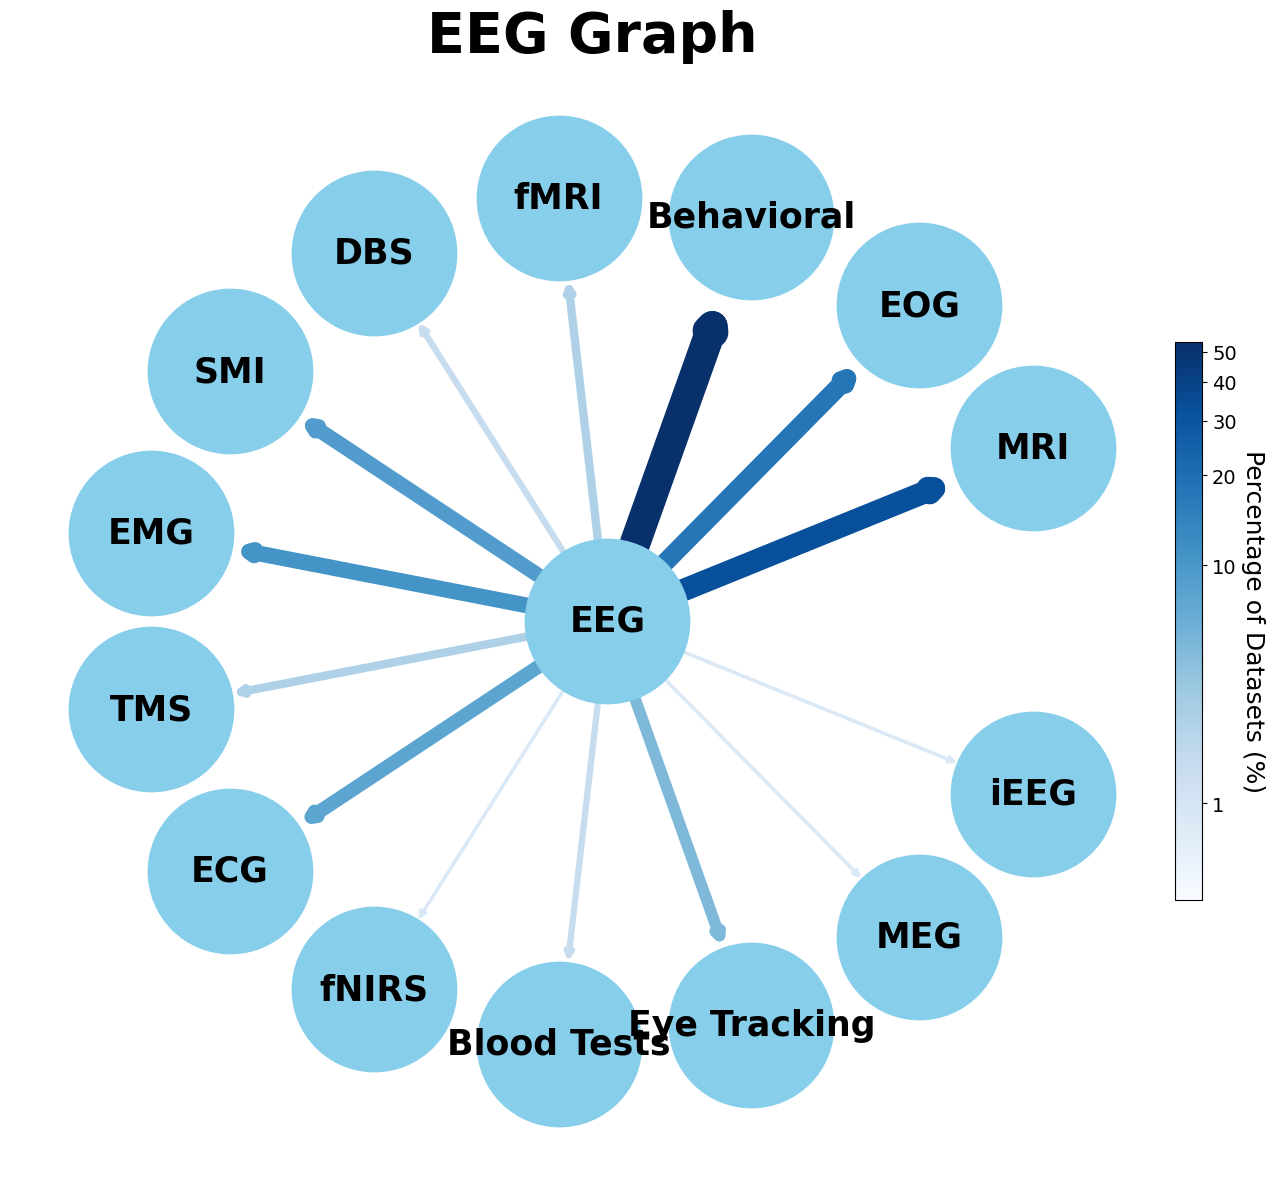

In [ ]:
create_and_draw_graph_percentages('EEG', df_fig2_additionalModalities, df_fig2, 'EEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.1_percentages.svg', format='svg')
plt.savefig('results/v1.6/figure_3.1_percentages.png', format='png')

plt.show()

[50.0, 7.5, 22.5, 2.5, 5.0, 2.5]


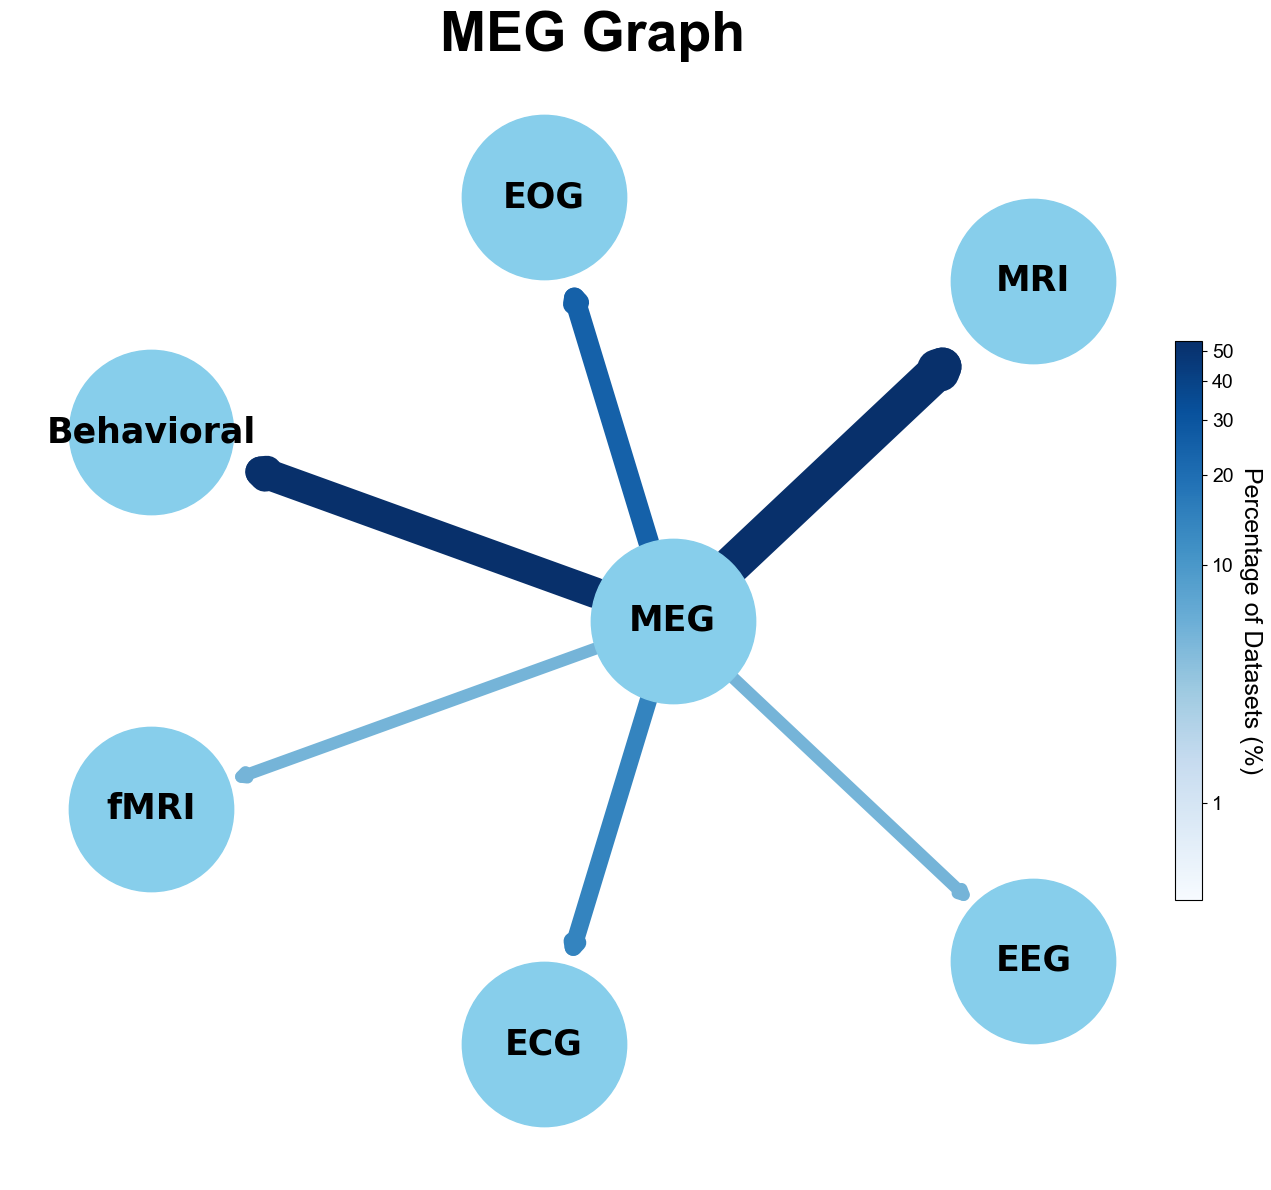

In [71]:
create_and_draw_graph_percentages('MEG', df_fig2_additionalModalities, df_fig2, 'MEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.2_percentages.svg', format='svg')
plt.savefig('results/v1.6/figure_3.2_percentages.png', format='png')

plt.show()


[35.294117647058826, 14.705882352941178, 2.941176470588235, 8.823529411764707, 2.941176470588235]


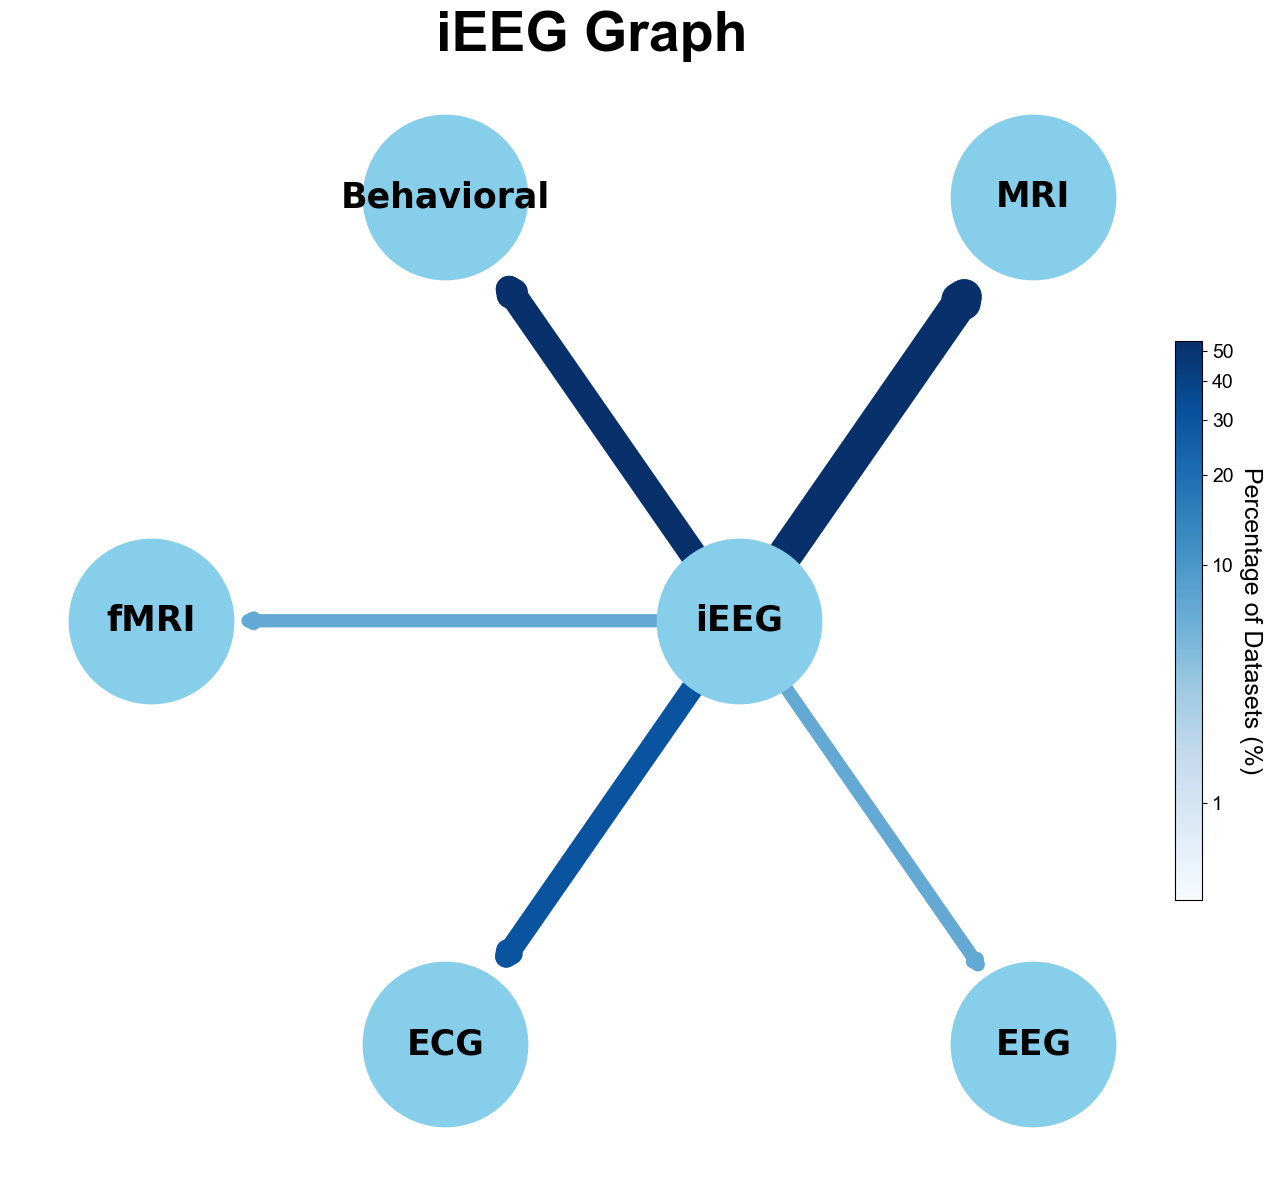

In [72]:
create_and_draw_graph_percentages('iEEG', df_fig2_additionalModalities, df_fig2, 'iEEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.3_percentages.svg', format='svg')
plt.savefig('results/v1.6/figure_3.3_percentages.png', format='png')

plt.show()

### Figure 4

Figure 4 - Published date x number of datasets x modality

A line graph showing the number of publications over time, segmented by modality

denote that all of the data is combination - like mri is eeg-mri

denote this is over evolution of nemar/openneuro, thats how old database is

take top 3 eeg/meg/ieeg on one plot, and then the other modalities on another plot

In [ ]:
df_fig4 = df[['EEG Modality', 
              'MEG Modality', 
              'iEEG Modality',
              'Published date',
              'Participants']]

df_fig4.rename(columns={
    'EEG Modality': 'EEG',
    'MEG Modality': 'MEG',
    'iEEG Modality': 'iEEG'
}, inplace=True)

# Initialize the dictionary with empty dataframes
dfs_by_modalities = {col: pd.DataFrame(columns=df_fig4.columns) for col in df_fig4.columns if col not in ['Published date', 'Participants']}

# Populate the dataframes
for index, row in df_fig4.iterrows():
    for col in dfs_by_modalities.keys():
        if pd.notna(row[col]):
            dfs_by_modalities[col].loc[len(dfs_by_modalities[col])] = row

# Convert 'Published date' to datetime for sorting and compute cumulative metrics
for modality, modality_df in dfs_by_modalities.items():
    modality_df = modality_df.copy()
    modality_df['Published date'] = pd.to_datetime(modality_df['Published date'])
    modality_df = modality_df.sort_values(by='Published date').reset_index(drop=True)

    # Cumulative count of publications
    modality_df['Cumulative Publications'] = range(1, len(modality_df) + 1)
    
    # Compute cumulative participants by iterating row-by-row
    cum_participants = 0.0
    cum_list = []
    for val in modality_df['Participants']:
        # Try direct numeric conversion
        p = pd.to_numeric(val, errors='coerce')
        cum_participants += float(p)
        cum_list.append(cum_participants)
    
    modality_df['Cumulative Participants'] = cum_list

    # Store back the processed dataframe
    dfs_by_modalities[modality] = modality_df

# Create subplots with two side-by-side plots
from plotly.subplots import make_subplots

df_fig4_figure = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Cumulative Dataset Publications', 'Cumulative Number of Participants')
)

# Create a color palette and map each modality to a color
modalities = list(dfs_by_modalities.keys())
palette = px.colors.qualitative.Plotly
color_map = {modality: palette[i % len(palette)] for i, modality in enumerate(modalities)}

for modality, modality_df in dfs_by_modalities.items():
    color = color_map[modality]
    
    # Publications (left subplot)
    df_fig4_figure.add_trace(go.Scatter(
        x=modality_df['Published date'],
        y=modality_df['Cumulative Publications'],
        mode='lines',
        name=f'{modality}',
        line=dict(color=color),
        hovertemplate='%{x}<br>%{y} publications',
        legendgroup=modality,
        showlegend=True
    ), row=1, col=1)

    # Participants (right subplot)
    if 'Cumulative Participants' in modality_df.columns:
        df_fig4_figure.add_trace(go.Scatter(
            x=modality_df['Published date'],
            y=modality_df['Cumulative Participants'],
            mode='lines',
            name=f'{modality}',
            line=dict(color=color),
            hovertemplate='%{x}<br>%{y} participants',
            legendgroup=modality,
            showlegend=False  # Don't show duplicate legend entries
        ), row=1, col=2)

df_fig4_figure.update_layout(
    title={
        'text': 'Dataset Publications and Participants Over Time for Primary Modalities',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'family': 'Arial', 'size': 24}
    },
    font={'family': 'Arial', 'size': 14},
    legend={'font': {'family': 'Arial', 'size': 14}},
    width=1400,
    height=600
)

# Update y-axis titles
df_fig4_figure.update_yaxes(title_text="Cumulative Publications", row=1, col=1)
df_fig4_figure.update_yaxes(title_text="Cumulative Participants", row=1, col=2)
df_fig4_figure.update_xaxes(title_text="Published Date", row=1, col=1)
df_fig4_figure.update_xaxes(title_text="Published Date", row=1, col=2)

df_fig4_figure.show()

# Save the figure as PNG and SVG
df_fig4_figure.write_image("results/v1.6/figure_4-2.png", width=1400, height=600)
df_fig4_figure.write_image("results/v1.6/figure_4-2.svg", width=1400, height=600)


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_52859/2839628378.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Figure 5.1

Figure 5 - EEG channel histogram (see which are most common)

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/131949960.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/131949960.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



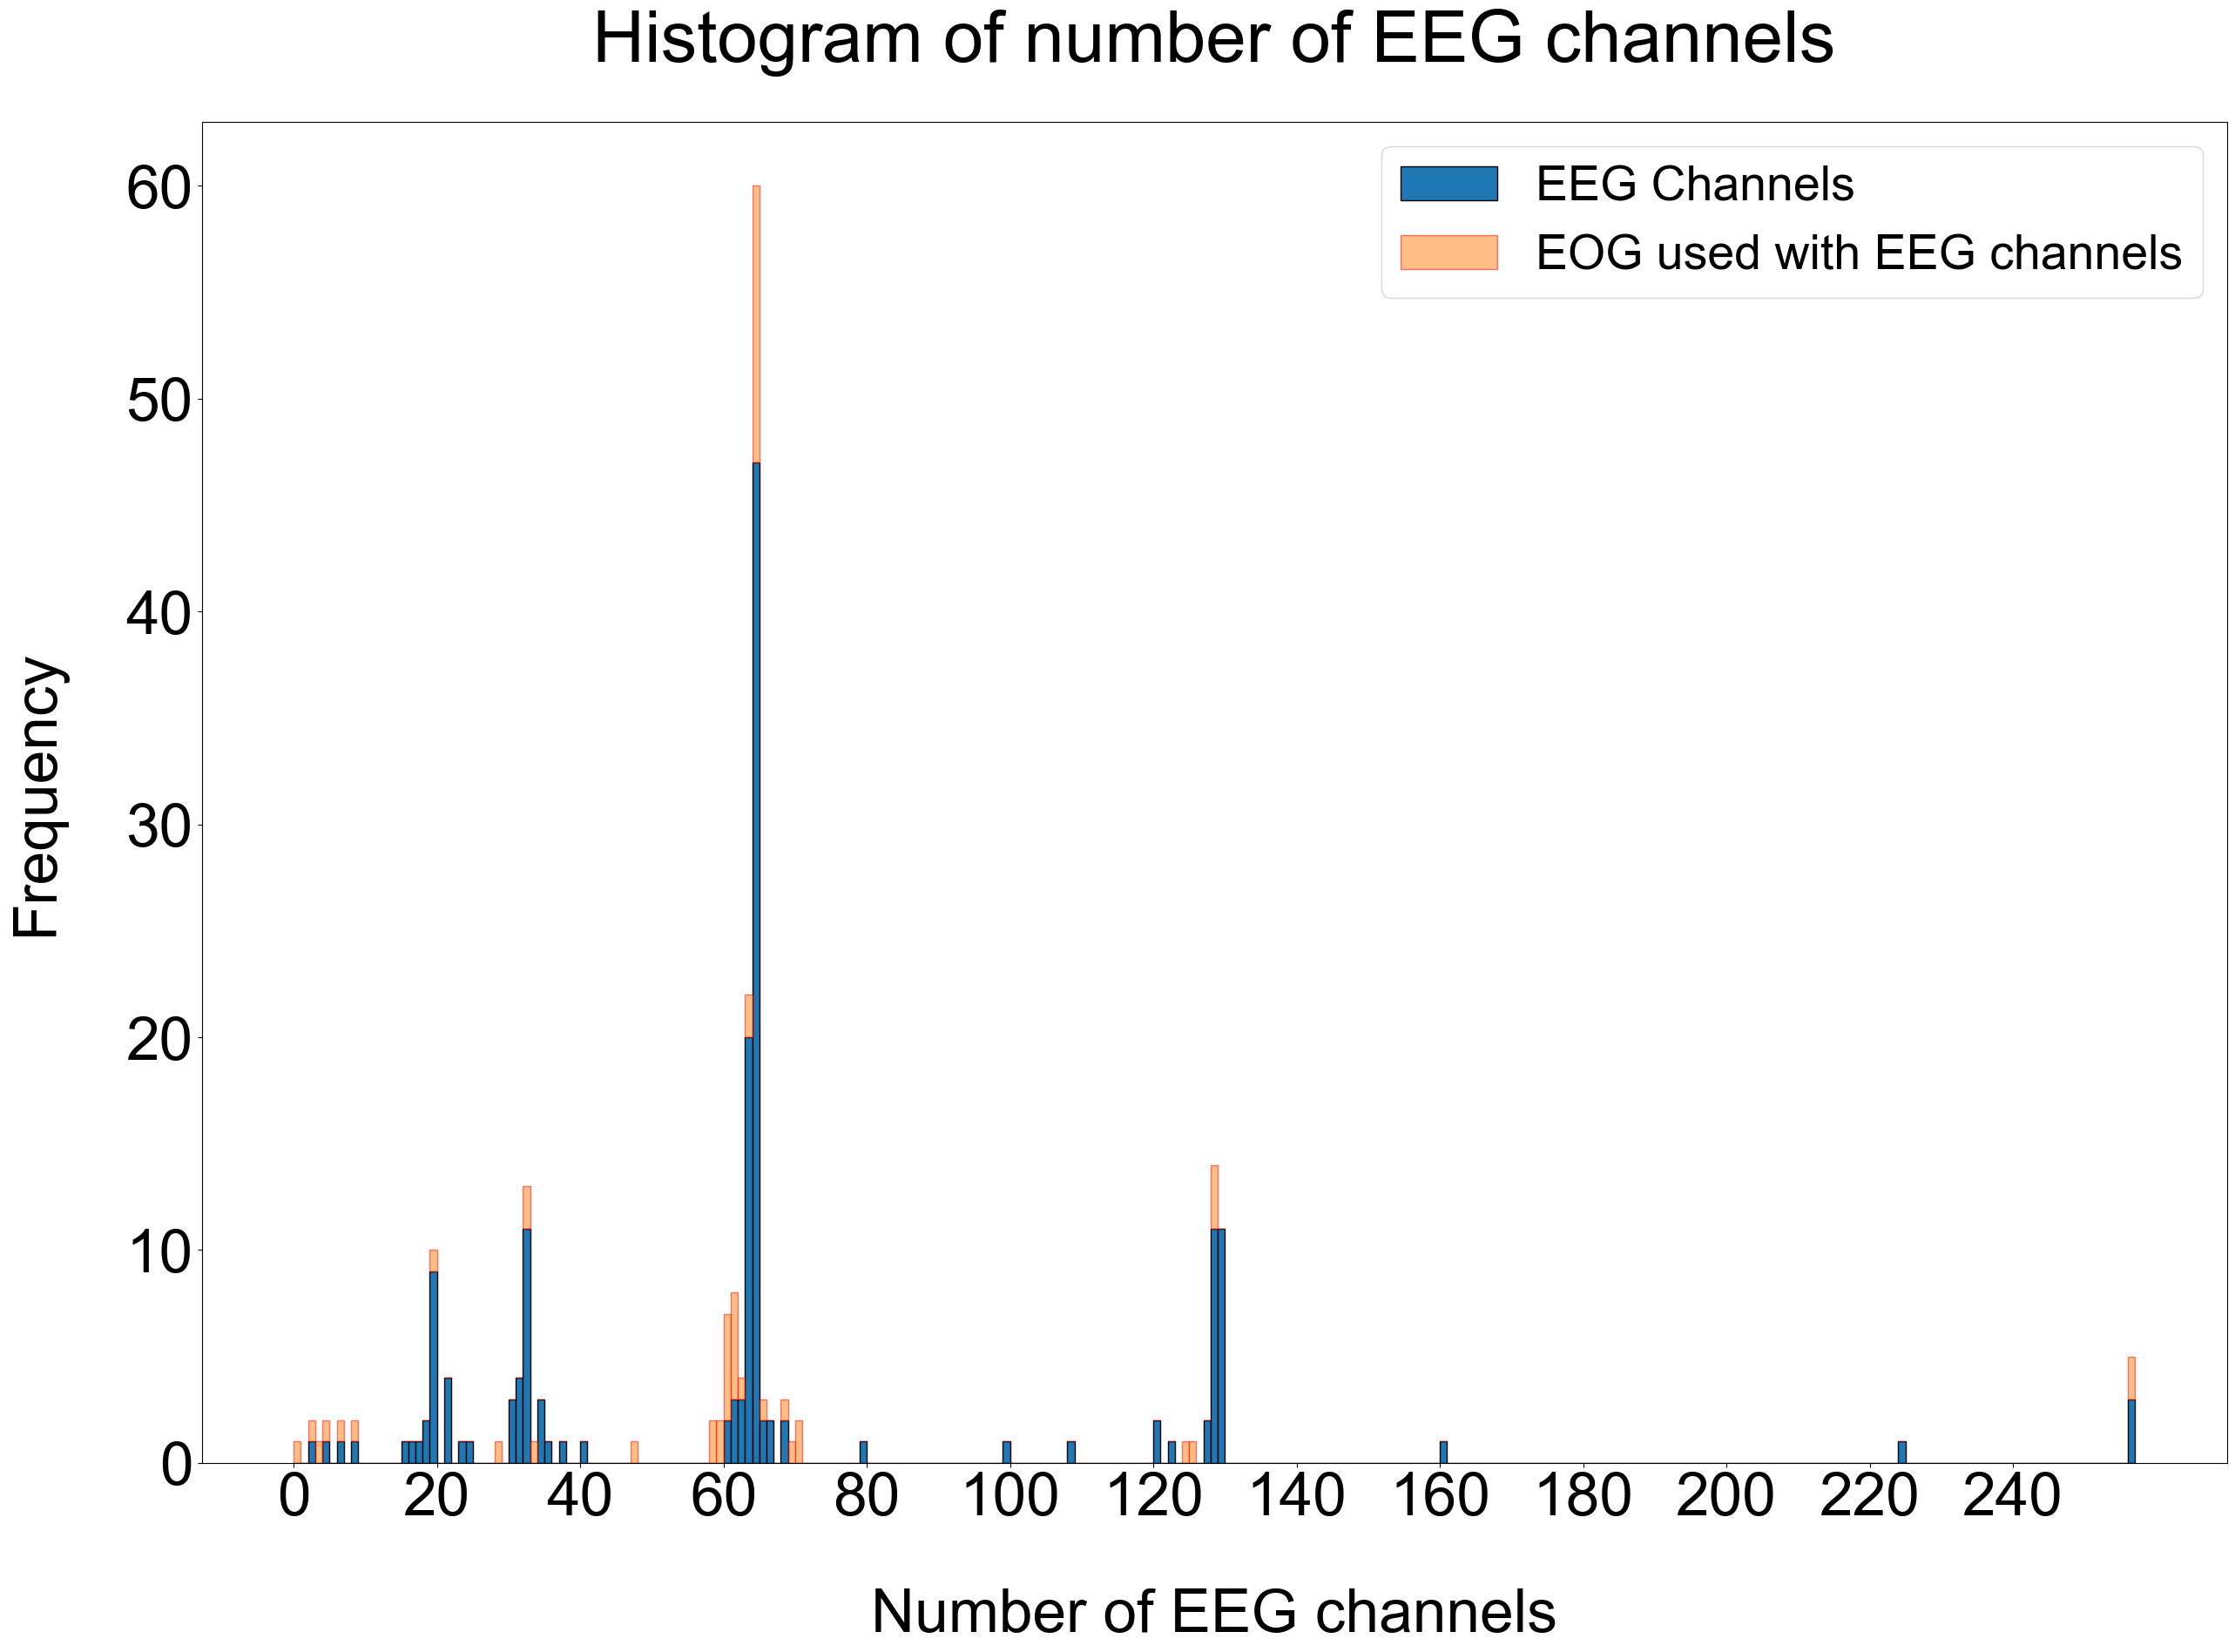

In [ ]:
df_eeg_channels = df['EEG channels']
df_eeg_channels.replace("n/a", "", inplace=True)
df_eeg_channels.dropna()

# Convert the EEG channels to numeric, forcing errors to NaN
df_eeg_channels = pd.to_numeric(df_eeg_channels, errors='coerce')

# Drop NaN values
df_eeg_channels.dropna(inplace=True)

df_eog_channels = df[['EEG channels', 'EOG channels']]
df_eog_channels.dropna(inplace=True)
df_eog_channels.drop(columns=['EOG channels'], inplace=True)
df_eog_channels = df_eog_channels.apply(pd.to_numeric, errors='coerce')
df_eog_channels.dropna(inplace=True)

# Define the number of bins for the histogram
BIN_COUNT_EEG = int(df_eeg_channels.max())

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Create the histogram without EOG data
fig_eeg, ax_eeg = plt.subplots(figsize=(30, 20))  # Increase the width of the figure
hist_eeg, bin_edges = np.histogram(df_eeg_channels, bins=BIN_COUNT_EEG)

# Plot the EOG data on the same histogram, but at the top of each bar/bin
hist_eog, _ = np.histogram(df_eog_channels, bins=bin_edges)
hist_eeg -= hist_eog
hist_eeg[-1] -= 2

# Plot the histogram
ax_eeg.bar(bin_edges[:-1], hist_eeg, width=np.diff(bin_edges), label='EEG Channels', edgecolor="black", align="edge")
ax_eeg.bar(bin_edges[:-1], hist_eog, width=np.diff(bin_edges), edgecolor="red", align="edge", alpha=0.5, label='EOG used with EEG channels', bottom=hist_eeg)
ax_eeg.set_xlabel('Number of EEG channels', fontsize=50, labelpad=50, fontfamily='Arial')  # Added labelpad for spacing
ax_eeg.set_ylabel('Frequency', fontsize=50, labelpad=50, fontfamily='Arial')  # Added labelpad for spacing
ax_eeg.set_title('Histogram of number of EEG channels', fontsize=60, pad=50, fontfamily='Arial')  # Added pad for spacing
ax_eeg.tick_params(axis='both', which='major', labelsize=50)

# Set x-axis ticks to be marked every 10
ax_eeg.set_xticks(np.arange(0, max(bin_edges), 20))

ax_eeg.legend(fontsize='40')

# Save the plot as a PNG and an SVG
fig_eeg.savefig('results/v1.6/figure_5.1.png', format='png')
fig_eeg.savefig('results/v1.6/figure_5.1.svg', format='svg')

plt.show()

### Figure 5.2

Figure 5 - MEG channel histogram w/ MRI data

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/3069420697.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/3069420697.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



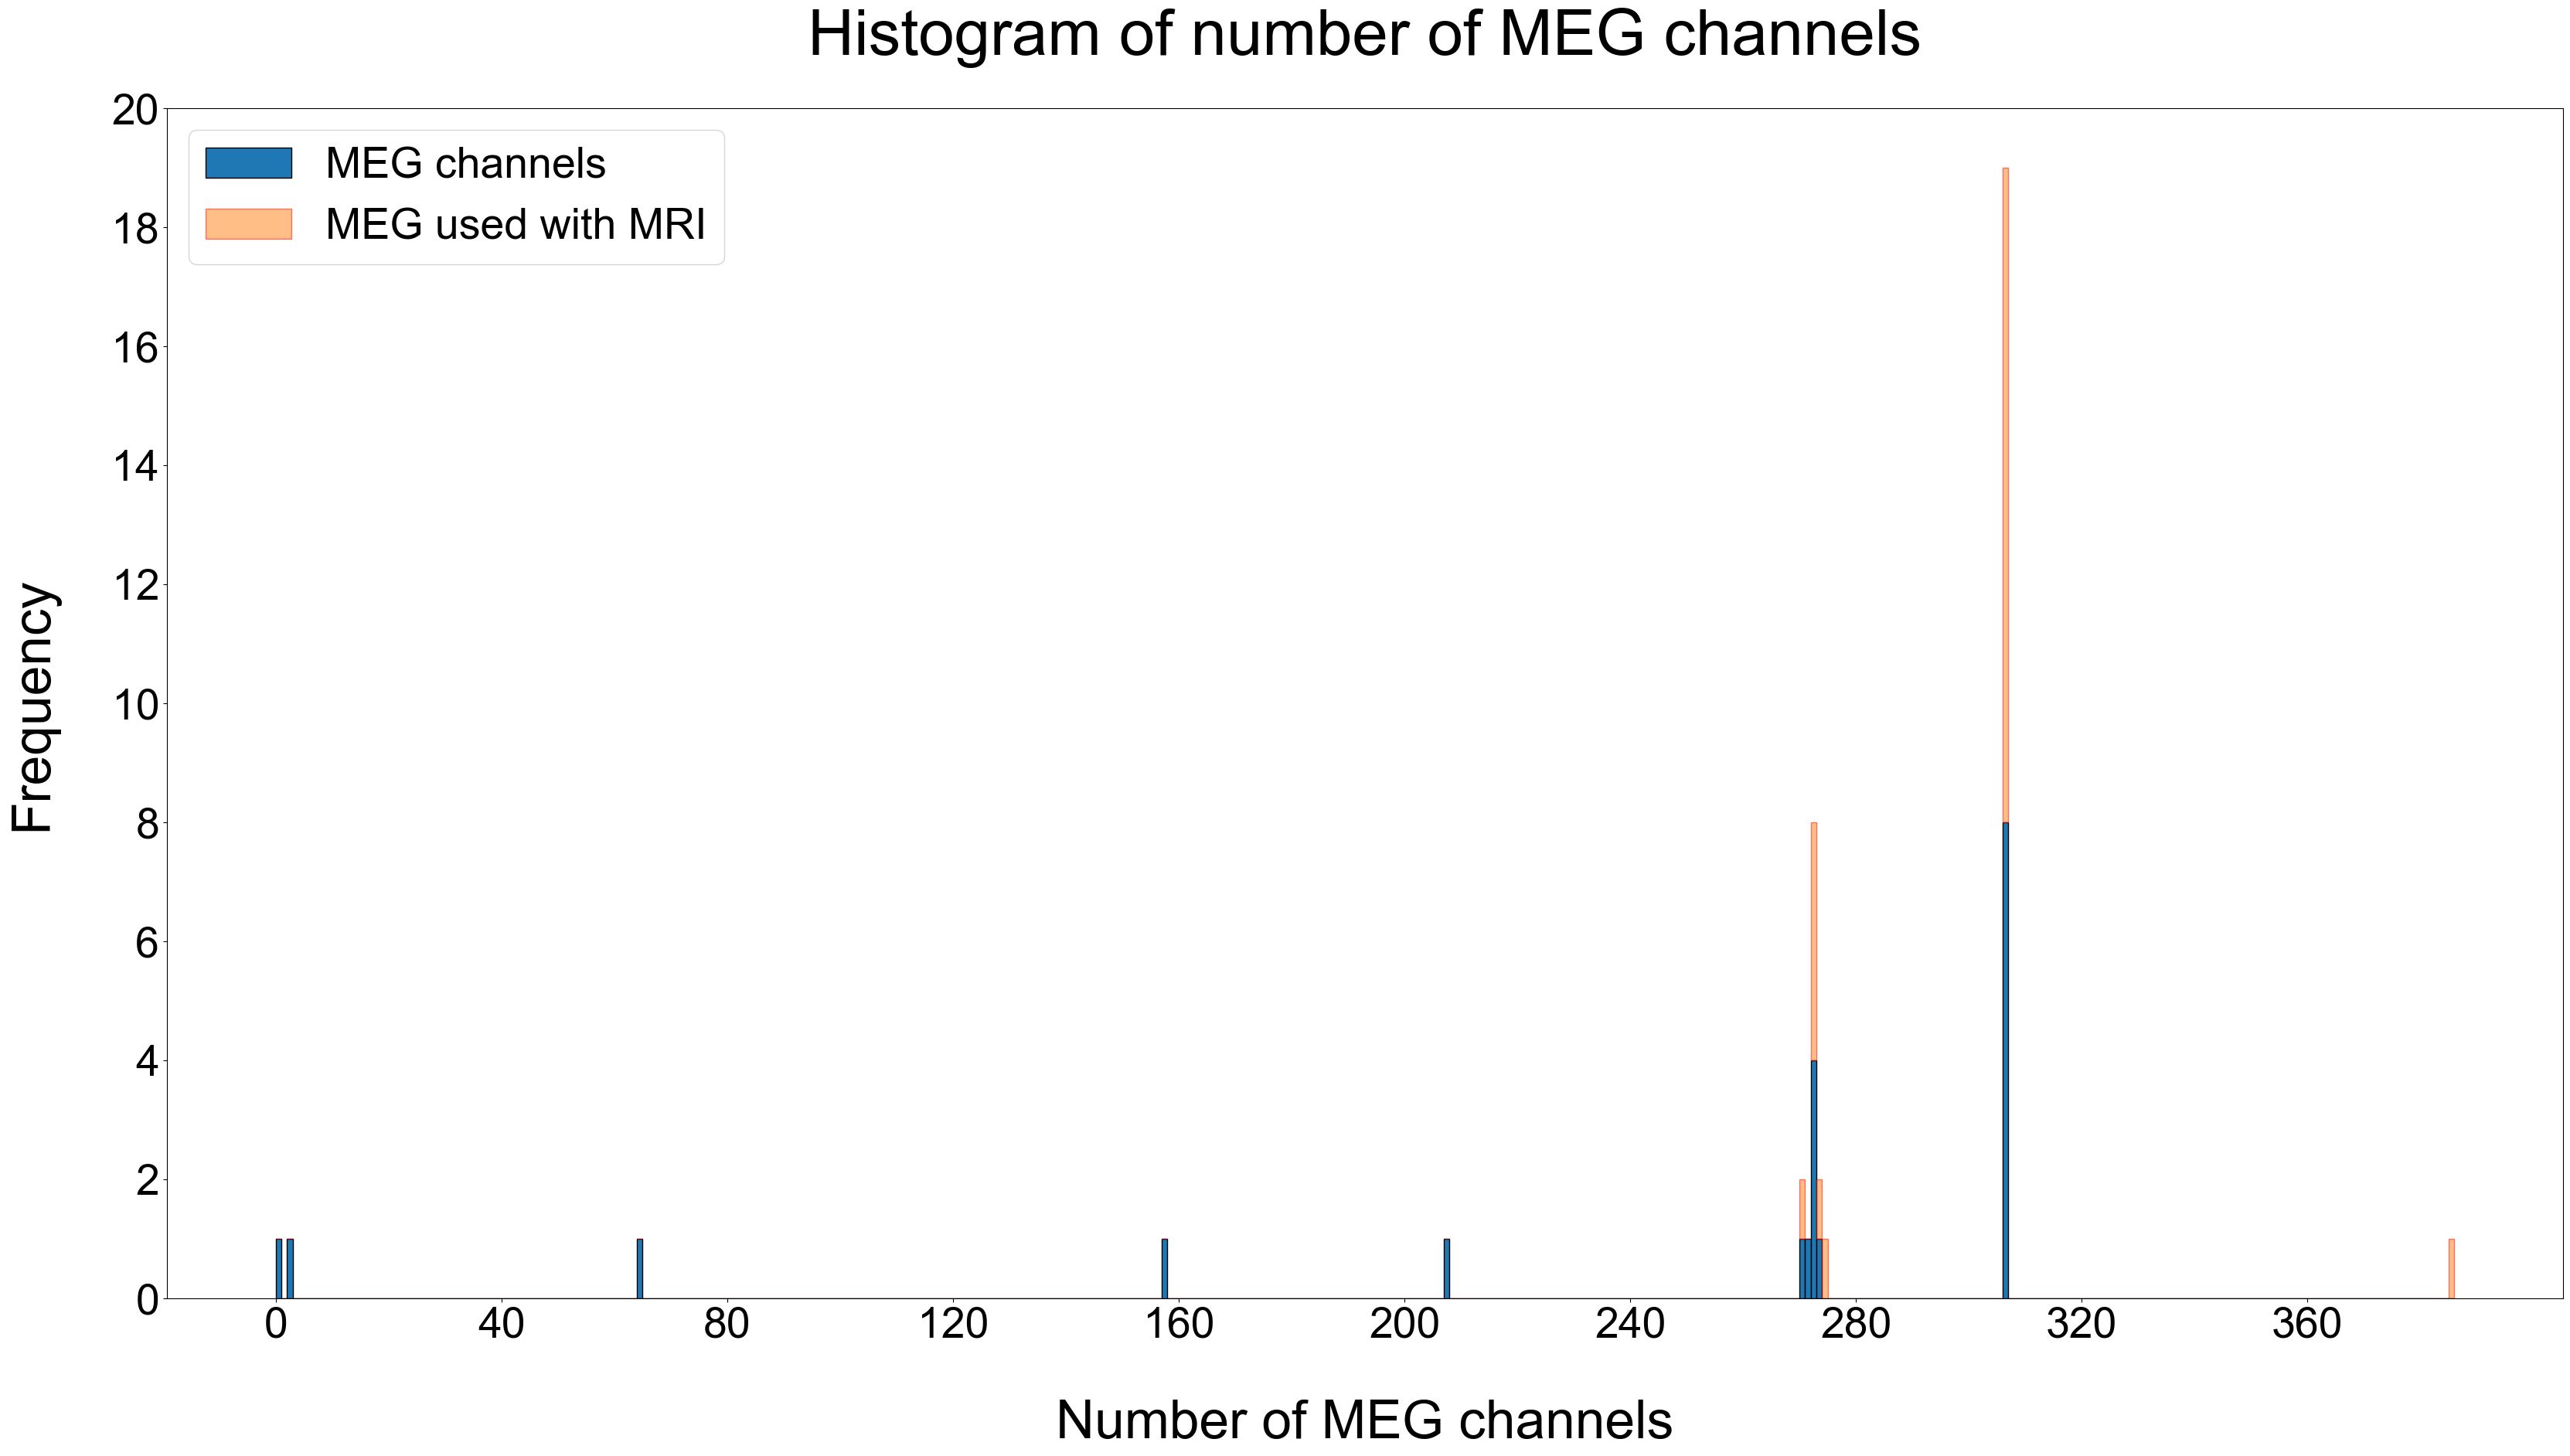

In [ ]:
df_meg_channels = df['MEG channels']
df_meg_channels.replace("n/a", "", inplace=True)
df_meg_channels.dropna()

# Convert the MEG channels to numeric, forcing errors to NaN
df_meg_channels = pd.to_numeric(df_meg_channels, errors='coerce')
df_meg_channels.dropna(inplace=True)

df_mri_channels = df[['MEG channels', 'Has MRI']]
df_mri_channels.dropna(inplace=True)
df_mri_channels.drop(columns=['Has MRI'], inplace=True)
df_mri_channels = df_mri_channels.apply(pd.to_numeric, errors='coerce')
df_mri_channels.dropna(inplace=True)

# Define the number of bins for the histogram
BIN_COUNT_MEG = int(df_meg_channels.max())  # Ensure the bins cover the range from 0 to max MEG channel count

# Set the font to Arial for all text elements
plt.rcParams['font.family'] = 'Arial'

# Create the histogram without MRI data
fig_meg, ax_meg = plt.subplots(figsize=(40, 20))  # Increase the width of the figure
hist_meg, bin_edges = np.histogram(df_meg_channels, bins=np.arange(0, BIN_COUNT_MEG + 2))  # Use np.arange to define bin edges

# Plot the MRI data on the same histogram, but at the top of each bar/bin
hist_mri, _ = np.histogram(df_mri_channels, bins=np.arange(0, BIN_COUNT_MEG + 2))
hist_meg -= hist_mri

# Plot the histogram
ax_meg.bar(bin_edges[:-1], hist_meg, width=np.diff(bin_edges), label='MEG channels', edgecolor="black", align="edge")
ax_meg.bar(bin_edges[:-1], hist_mri, width=np.diff(bin_edges), edgecolor="red", align="edge", alpha=0.5, label='MEG used with MRI', bottom=hist_meg)

ax_meg.set_xlabel('Number of MEG channels', fontsize=50, labelpad=50, fontfamily='Arial')
ax_meg.set_ylabel('Frequency', fontsize=50, labelpad=50, fontfamily='Arial')
ax_meg.set_title('Histogram of number of MEG channels', fontsize=60, pad=50, fontfamily='Arial')
ax_meg.tick_params(axis='both', which='major', labelsize=40)

# Set y-axis ticks to go up to 20
ax_meg.set_yticks(np.arange(0, 21, 2))

# Set x-axis ticks to be marked every 20
ax_meg.set_xticks(np.arange(0, max(bin_edges), 40))

ax_meg.legend(fontsize='40')

# Save the plot as a PNG and an SVG
fig_meg.savefig('results/v1.6/figure_5.2.png', format='png')
fig_meg.savefig('results/v1.6/figure_5.2.svg', format='svg')

plt.show()

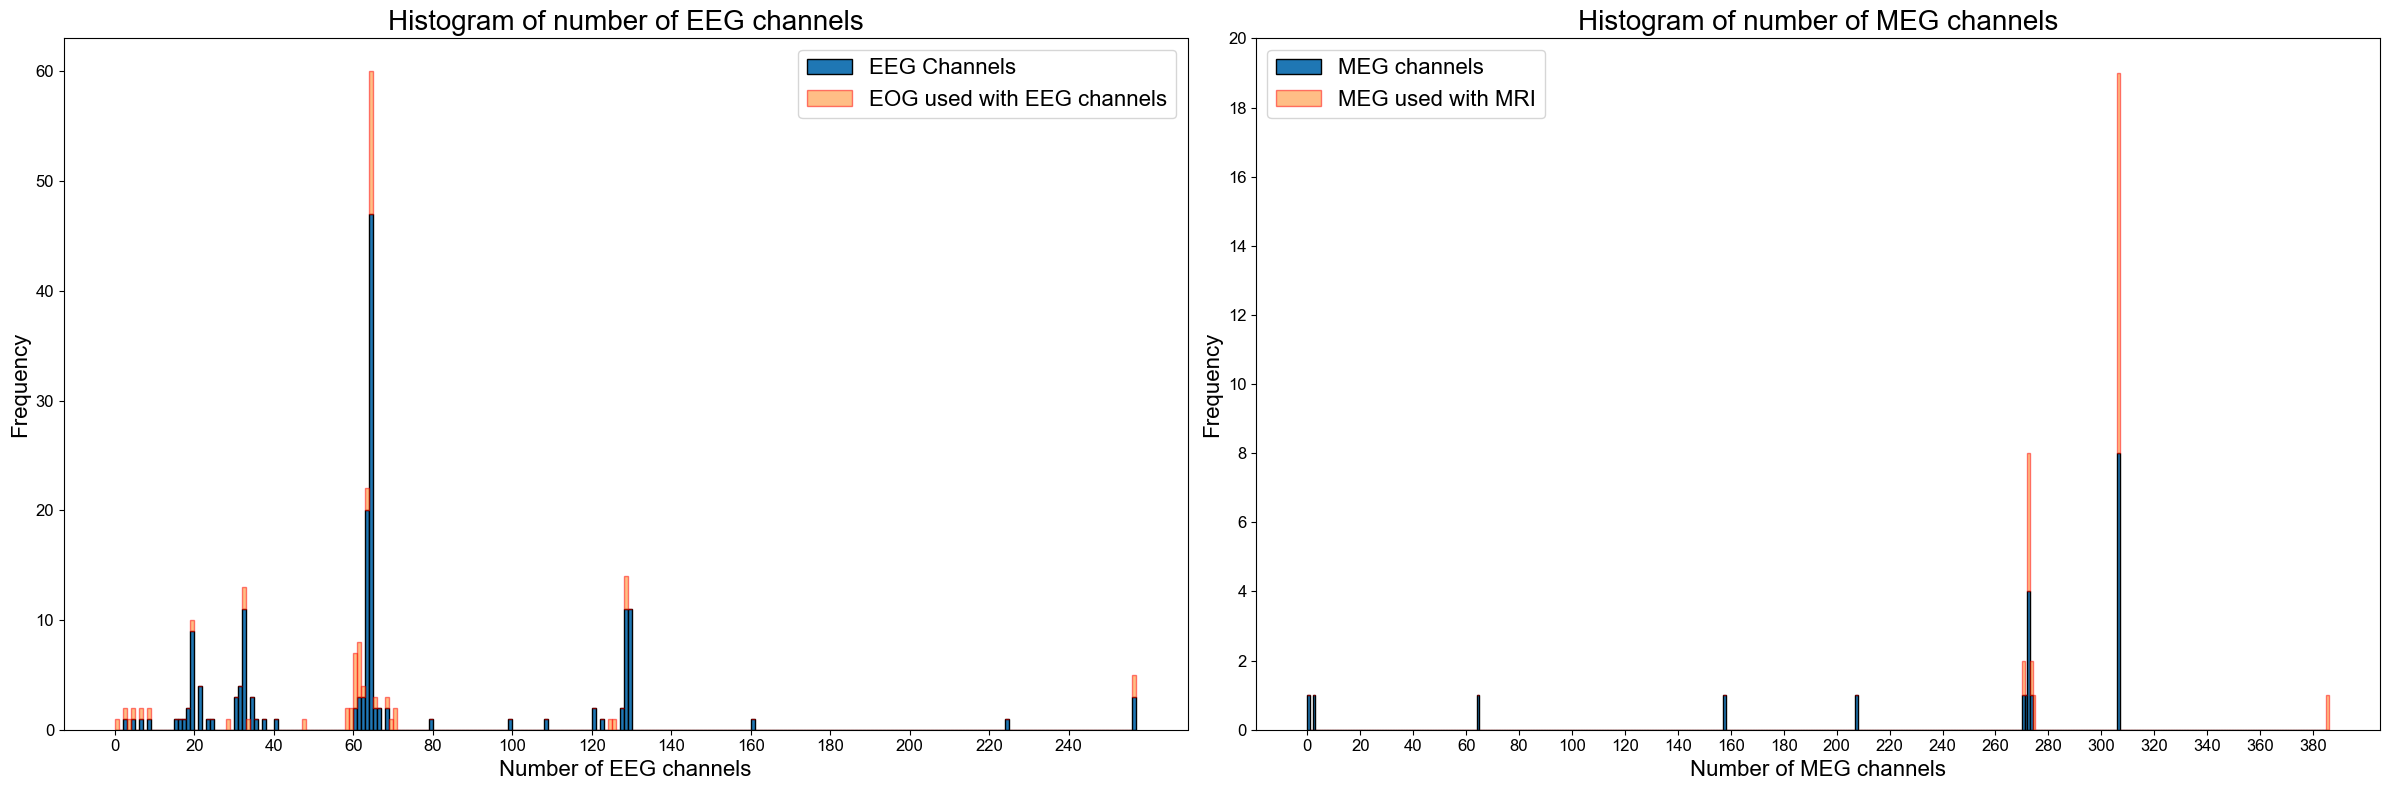

In [ ]:
# Create a figure with 2 horizontal subplots
fig, (ax_eeg, ax_meg) = plt.subplots(1, 2, figsize=(24, 8))

# EEG Plot (left subplot)
hist_eeg, bin_edges_eeg = np.histogram(df_eeg_channels, bins=BIN_COUNT_EEG)
hist_eog, _ = np.histogram(df_eog_channels, bins=bin_edges_eeg)
hist_eeg -= hist_eog
hist_eeg[-1] -= 2

ax_eeg.bar(bin_edges_eeg[:-1], hist_eeg, width=np.diff(bin_edges_eeg), 
           label='EEG Channels', edgecolor="black", align="edge")
ax_eeg.bar(bin_edges_eeg[:-1], hist_eog, width=np.diff(bin_edges_eeg), 
           edgecolor="red", align="edge", alpha=0.5, 
           label='EOG used with EEG channels', bottom=hist_eeg)
ax_eeg.set_xlabel('Number of EEG channels', fontsize=16)
ax_eeg.set_ylabel('Frequency', fontsize=16)
ax_eeg.set_title('Histogram of number of EEG channels', fontsize=20)
ax_eeg.tick_params(axis='both', which='major', labelsize=12)
ax_eeg.set_xticks(np.arange(0, max(bin_edges_eeg), 20))
ax_eeg.legend(fontsize=16)

# MEG Plot (right subplot)
hist_meg, bin_edges_meg = np.histogram(df_meg_channels, bins=np.arange(0, BIN_COUNT_MEG + 2))
hist_mri, _ = np.histogram(df_mri_channels, bins=np.arange(0, BIN_COUNT_MEG + 2))
hist_meg -= hist_mri

ax_meg.bar(bin_edges_meg[:-1], hist_meg, width=np.diff(bin_edges_meg), 
           label='MEG channels', edgecolor="black", align="edge")
ax_meg.bar(bin_edges_meg[:-1], hist_mri, width=np.diff(bin_edges_meg), 
           edgecolor="red", align="edge", alpha=0.5, 
           label='MEG used with MRI', bottom=hist_meg)
ax_meg.set_xlabel('Number of MEG channels', fontsize=16)
ax_meg.set_ylabel('Frequency', fontsize=16)
ax_meg.set_title('Histogram of number of MEG channels', fontsize=20)
ax_meg.tick_params(axis='both', which='major', labelsize=12)
ax_meg.set_yticks(np.arange(0, 21, 2))
ax_meg.set_xticks(np.arange(0, max(bin_edges_meg), 20))
ax_meg.legend(fontsize=16)

plt.tight_layout()

# Save the combined plot
fig.savefig('results/v1.5/figure_5.png', format='png', bbox_inches='tight')
fig.savefig('results/v1.5/figure_5.svg', format='svg', bbox_inches='tight')

plt.show()


### Figure 7

Figure 5 - EEG channel histogram (see which are most common)

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_30748/2548039866.py:28: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





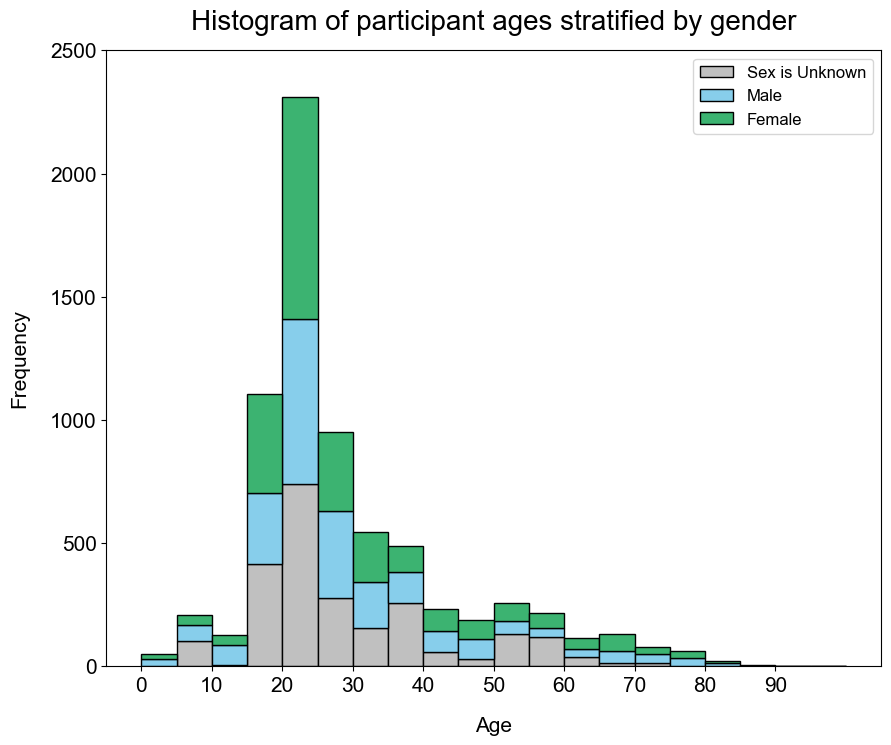

In [ ]:
import os
from io import StringIO
import pandas as pd

# Create a DataFrame with age and sex as parameters
df_ages_sexes = pd.DataFrame(columns=['age', 'sex'])

# Iterate through each file in the directory
for filename in os.listdir('data/participant_ages'):
    if filename.endswith('.txt'):
        # Read the file into a DataFrame
        file_path = os.path.join('data/participant_ages', filename)
        df_temp = pd.read_csv(file_path, sep='\t')

        # Check if both 'age' and 'sex' columns exist in df_temp
        if 'age' in df_temp.columns and 'sex' in df_temp.columns:
            # Concatenate the 'age' and 'sex' columns to the df_ages_sexes DataFrame
            df_ages_sexes = pd.concat([df_ages_sexes, df_temp[['age', 'sex']]], ignore_index=True)
        elif 'age' in df_temp.columns and 'sex' not in df_temp.columns:
            # Add the 'age' column values to df_ages_sexes with NaN for 'sex'
            df_temp['sex'] = np.nan
            df_ages_sexes = pd.concat([df_ages_sexes, df_temp[['age', 'sex']]], ignore_index=True)

# post-processing
df_ages_sexes['age'] = pd.to_numeric(df_ages_sexes['age'], errors='coerce')
df_ages_sexes = df_ages_sexes.dropna(subset=['age'])
df_ages_sexes['sex'] = df_ages_sexes['sex'].str.lower()
df_ages_sexes['sex'].replace({'male': 'm', 'female': 'f', 'w': 'f'}, inplace=True)

# Create a stacked histogram for age=null, male, and female

# Define bins
bins = np.arange(0, 105, 5)

# Define the colors for each category
colors = ['silver', 'skyblue', 'mediumseagreen', 'lightcoral']

# Create the histogram for age=null
df_ages_no_sex = df_ages_sexes[df_ages_sexes['sex'].isna()]
hist_no_sex, bin_edges = np.histogram(df_ages_no_sex['age'], bins=bins)

# Create the histogram for males
df_ages_male = df_ages_sexes[df_ages_sexes['sex'] == 'm']
hist_male, _ = np.histogram(df_ages_male['age'], bins=bin_edges)

# Create the histogram for females
df_ages_female = df_ages_sexes[df_ages_sexes['sex'] == 'f']
hist_female, _ = np.histogram(df_ages_female['age'], bins=bin_edges)

# Create the histogram for nonbinary
df_ages_nb = df_ages_sexes[df_ages_sexes['sex'] == 'nb']
hist_nb, _ = np.histogram(df_ages_nb['age'], bins=bin_edges)

# Set the font to Arial for all text elements
plt.rcParams['font.family'] = 'Arial'

# Plot the stacked histogram
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(bin_edges[:-1], hist_no_sex, width=np.diff(bin_edges), edgecolor="black", 
       align="edge", color=colors[0], label='Sex is Unknown')
ax.bar(bin_edges[:-1], hist_male, width=np.diff(bin_edges), edgecolor="black", 
       align="edge", color=colors[1], label='Male', bottom=hist_no_sex)
ax.bar(bin_edges[:-1], hist_female, width=np.diff(bin_edges), edgecolor="black", 
       align="edge", color=colors[2], label='Female', bottom=hist_no_sex + hist_male)

# Set all text properties to use Arial font
ax.set_xlabel('Age', fontfamily='Arial', fontsize=15, labelpad=15)
ax.set_ylabel('Frequency', fontfamily='Arial', fontsize=15, labelpad=15)
ax.set_title('Histogram of participant ages stratified by gender', 
             fontfamily='Arial', fontsize=20, pad=15)
ax.set_ylim(0, 2500)  # Set y-axis limit to 2500
ax.set_xticks(np.arange(0, max(bin_edges), 10))  # Set x-axis ticks every 5
ax.tick_params(axis='both', which='major', labelsize=15)

# Use Arial font for the legend
legend = ax.legend(prop={'family': 'Arial', 'size': 12})

# Save the plot as a PNG and an SVG
fig.savefig('results/v1.6/figure_6.png', format='png')
fig.savefig('results/v1.6/figure_6.svg', format='svg')

plt.show()


### Figure 8

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_47371/1225232046.py:39: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



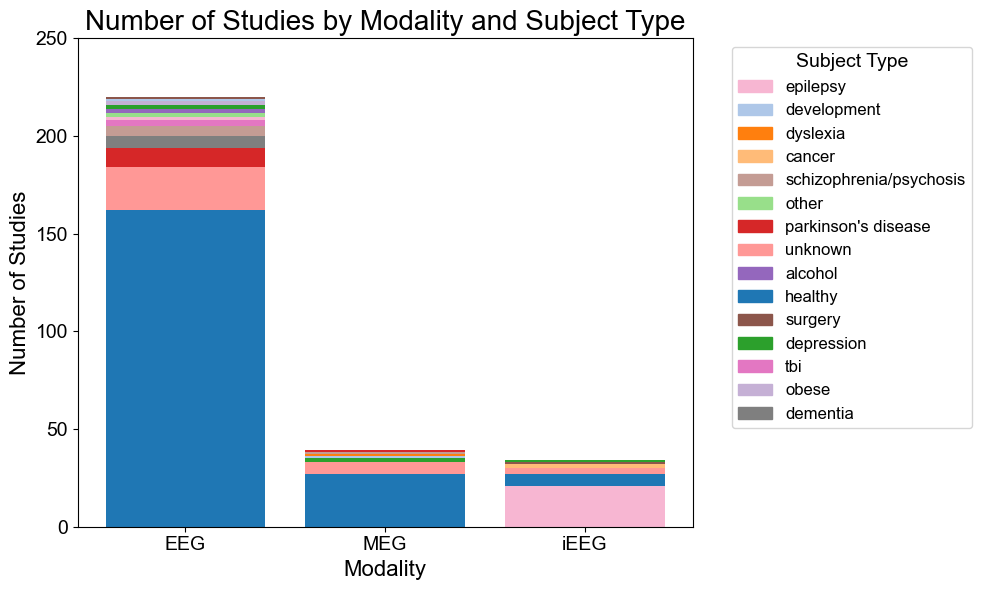

In [31]:
from matplotlib.cm import get_cmap

# Filter rows where modality columns are not null or empty
df_eeg = df[df['EEG Modality'].notna() & (df['EEG Modality'] != '')]
df_meg = df[df['MEG Modality'].notna() & (df['MEG Modality'] != '')]
df_ieeg = df[df['iEEG Modality'].notna() & (df['iEEG Modality'] != '')]

# Count the number of studies for each modality
eeg_counts = df_eeg['FOR FIG - Type Subject'].value_counts().to_dict()
meg_counts = df_meg['FOR FIG - Type Subject'].value_counts().to_dict()
ieeg_counts = df_ieeg['FOR FIG - Type Subject'].value_counts().to_dict()

# Combine all unique subject types from the three modalities
all_subject_types = set(eeg_counts.keys()).union(set(meg_counts.keys()), set(ieeg_counts.keys()))
data = {subject: [eeg_counts.get(subject, 0), meg_counts.get(subject, 0), ieeg_counts.get(subject, 0)] for subject in all_subject_types}
df_subject_counts = pd.DataFrame(data, index=['EEG', 'MEG', 'iEEG']).T

# For each modality, sort the subjects by count in descending order
sorted_subject_counts = {}
for modality in df_subject_counts.columns:
    sorted_subject_counts[modality] = df_subject_counts[modality].sort_values(ascending=False)

# Remove the 'twins' category and add its count to 'healthy'
if 'twins' in df_subject_counts.index:
    df_subject_counts.loc['healthy'] += df_subject_counts.loc['twins']
    df_subject_counts.drop('twins', inplace=True)

# Update the sorted_subject_counts dictionary
for modality in df_subject_counts.columns:
    sorted_subject_counts[modality] = df_subject_counts[modality].sort_values(ascending=False)

# Create a stacked bar plot
x = np.arange(len(df_subject_counts.columns))  # X-axis positions
bar_width = 0.8  # Width of the bars

plt.figure(figsize=(10, 6))

# Use a distinct colormap with enough colors
cmap = get_cmap('tab20')  # Use 'tab20' for 20 distinct colors
# colors = [cmap(i) for i in range(len(df_subject_counts.index))]
swaps = [(13, 0), (4, 11), (13, 9)]
colors = [cmap(i) for i in range(16)]
for a, b in swaps:
    colors[a], colors[b] = colors[b], colors[a]

# For each modality, plot the bars in descending order by count
for i, modality in enumerate(df_subject_counts.columns):
    bottom = 0
    # Sort the subjects for this modality by count in descending order
    for j, (subject_type, count) in enumerate(sorted_subject_counts[modality].items()):
        if count > 0:  # Only plot if count is positive
            plt.bar(i, count, bar_width, bottom=bottom, label=f"{subject_type}" if i == 0 and bottom == 0 else "", 
                    color=colors[list(df_subject_counts.index).index(subject_type)])
            bottom += count

# Add labels and title
plt.xticks(x, df_subject_counts.columns, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Modality', fontsize=16)
plt.ylabel('Number of Studies', fontsize=16)
plt.title('Number of Studies by Modality and Subject Type', fontsize=20, loc='center')
plt.ylim(0, 250)

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Create a separate legend for all subject types
handles = [plt.Rectangle((0,0),1,1, color=colors[list(df_subject_counts.index).index(subject)]) 
           for subject in df_subject_counts.index]
plt.legend(handles, df_subject_counts.index, title='Subject Type', 
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Save the plot as PNG and SVG
plt.savefig('results/v1.6/figure_8_v3.png', format='png', bbox_inches='tight')
plt.savefig('results/v1.6/figure_8_v3.svg', format='svg', bbox_inches='tight')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_34296/3501246675.py:22: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



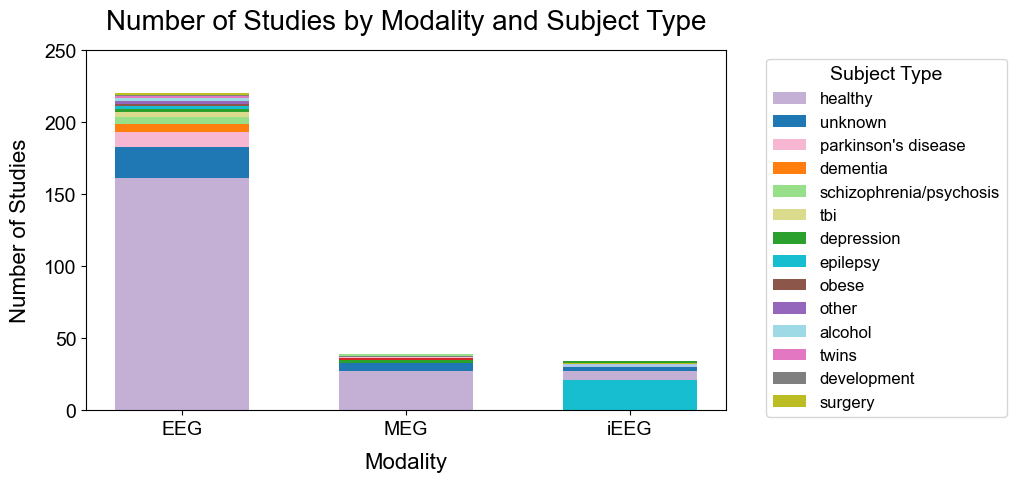

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

def plot_stacked_bars(
    data, 
    stack_orders, 
    group_order=None, 
    bar_width=0.6, 
    figsize=(8, 6), 
    title="Stacked Bar Chart",
    ax=None
):

    # Determine ordering of groups
    if group_order is None:
        group_order = list(stack_orders.keys())
    
    # Gather all categories
    all_categories = {cat for order in stack_orders.values() for cat in order}
    
    cmap = plt.cm.get_cmap('tab20', len(all_categories))
    # color_map = {cat: cmap(i) for i, cat in enumerate(np.random.permutation(sorted(all_categories)))}
    # color_map = {cat: cmap(i) for i, cat in enumerate(sorted(all_categories))}
    # Swap specific pairs of colors in the colormap
    swaps = [(0, 15), (9, 14), (4, 11), (6, 9)]
    colors = [cmap(i) for i in range(len(all_categories))]
    for a, b in swaps:
        colors[a], colors[b] = colors[b], colors[a]
    color_map = {cat: colors[i] for i, cat in enumerate(sorted(all_categories))}
    
    # Create figure/axis if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(group_order))
    
    # Draw each bar with its custom stack order
    for i, grp in enumerate(group_order):
        bottom = 0
        for cat in stack_orders[grp]:
            value = data.get(grp, {}).get(cat, 0)
            ax.bar(
                x[i], value, bar_width, bottom=bottom, 
                color=color_map[cat], 
                label=cat if i == 0 else ""
            )
            bottom += value
    ax.set_xticks(x)
    ax.set_xticklabels(group_order)
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend(title="Category")
    
    return ax

# Example usage
example_data = {
    'Group 1': {'Cat A': 3, 'Cat B': 2, 'Cat C': 1},
    'Group 2': {'Cat A': 1, 'Cat B': 2, 'Cat C': 4},
    'Group 3': {'Cat A': 2, 'Cat B': 1, 'Cat C': 3}
}
stack_orders = {
    'Group 1': ['Cat A', 'Cat B', 'Cat C'],
    'Group 2': ['Cat B', 'Cat C', 'Cat A'],
    'Group 3': ['Cat C', 'Cat A', 'Cat B']
}

df_eeg = df[df['EEG Modality'].notna() & (df['EEG Modality'] != '')]
df_meg = df[df['MEG Modality'].notna() & (df['MEG Modality'] != '')]
df_ieeg = df[df['iEEG Modality'].notna() & (df['iEEG Modality'] != '')]

modality_data = {
    'EEG': df_eeg['FOR FIG - Type Subject'].value_counts().to_dict(),
    'MEG': df_meg['FOR FIG - Type Subject'].value_counts().to_dict(),
    'iEEG': df_ieeg['FOR FIG - Type Subject'].value_counts().to_dict()
}

modality_stack_orders = {
    'EEG': sorted(modality_data['EEG'], key=modality_data['EEG'].get, reverse=True),
    'MEG': sorted(modality_data['MEG'], key=modality_data['MEG'].get, reverse=True),
    'iEEG': sorted(modality_data['iEEG'], key=modality_data['iEEG'].get, reverse=True)
}

cmap = plt.colormaps.get_cmap('tab20')  # Use 'tab20' for 20 distinct colors
print(cmap)

fig, ax = plt.subplots(figsize=(8, 6))
plot_stacked_bars(modality_data, modality_stack_orders, ax=ax)

# Add labels and title with padding
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Modality', fontsize=16, labelpad=10)  # Add padding to x label
plt.ylabel('Number of Studies', fontsize=16, labelpad=10)  # Add padding to y label
plt.legend(title='Subject Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.ylim(0, 250)
plt.title('Number of Studies by Modality and Subject Type', fontsize=20, loc='center', pad=15)  # Add padding to title
plt.gca().set_position([0.1, 0.2, 0.8, 0.6])  # Adjust the position of the graph to center it

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Save the plot as PNG and SVG
plt.savefig('results/v1.6/figure_8.png', format='png', bbox_inches='tight')
plt.savefig('results/v1.6/figure_8.svg', format='svg', bbox_inches='tight')


plt.show()

### Figure 9
create a figure of the various disorders versus number of participants, make it in log space

In [ ]:
df_fig9 = df['FOR FIG - Type Subject']

df_fig9.replace('?', np.nan, inplace=True)
df_fig9.dropna(inplace=True)

# Calculate the frequency of each unique value in df_fig9
value_counts = df_fig9.value_counts()

# # Create a bar plot (matplotlib version)
# plt.figure(figsize=(12, 6))
# value_counts.plot(kind='bar', log=False)
# plt.xlabel('Type of Subject')
# plt.ylabel('Frequency')
# plt.title('Number of studies on various subject types')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# Create a bar plot using plotly
fig = px.bar(value_counts, x=value_counts.index, y=value_counts.values, log_y=False)
fig.update_layout(
    title={
        'text': 'Number of Studies vs Subject Type',
        'x': 0.5,  # Center the title
        'xanchor': 'center'
    },
    xaxis_title='Type of Subject',
    yaxis_title='Frequency',
    xaxis_tickangle=-45,
    font=dict(color='black', size=14)  # Set the text color to black and font size to 14
)

fig.write_image("results/v1.5/figure_8.svg", format='svg')
fig.write_image("results/v1.5/figure_8.png", format='png')
fig.show()
